# Predicting House Sale Price (Gauss-Markov Conditions) 

In this module, we'll use a version of the "House Prices" dataset from Kaggle that has been ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, our task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Load the dataset from Thinkful's database

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
house_price = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#Close the connection after query is complete
engine.dispose()

### Clean dataset

In [6]:
#Drop features
drop_list = list((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(19).index)
drop_list.append('id')

house_price = house_price.drop(drop_list, axis=1)

#List of features that are string categoricals
str_cat_cols = list(house_price.describe(include=['O']).columns)

#Uniques within each variable
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(house_price.columns):
    uni_col.append(list(np.unique(house_price[col])))
    num_uni.append(len(np.unique(house_price[col])))
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(house_price[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(house_price.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni


#List of features that are numerical categoricals
#If a numerical variable is categorical, its unique values will tend to be close to each other and there shouldn't
#be too many unique values 
num_cat_cols = []
for col in list(house_price.columns):
    if col not in str_cat_cols:   
        if ((list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 2) or ((list(uniques[uniques['Category']==col]['Num Uniques'])[0] < 20) and (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 20))):
            num_cat_cols.append(col)
            
#List of features that are numerical continuous
cont_cols = []
for col in list(house_price.columns):
    if ((col not in str_cat_cols) and (col not in num_cat_cols)):
        cont_cols.append(col)
        
#Create new dataframe containing features of interest
sale_df = house_price[['saleprice', 'grlivarea', 'garagearea', 'totalbsmtsf', 'overallqual', 'paveddrive', 'centralair', 'yearremodadd']]

#Convert string categoricals ('paveddrive' and 'centralair') to dummy numerical
unique_paved = ['N', 'P', 'Y']
dummy_paveddrive = []
for row in sale_df['paveddrive']:
    for i in range(len(unique_paved)):
        if row == unique_paved[i]:
            dummy_paveddrive.append(i)
        
sale_df['paveddrive'] = dummy_paveddrive

unique_ac = ['N', 'Y']
dummy_ac = []
for row in sale_df['centralair']:
    for i in range(len(unique_ac)):
        if row == unique_ac[i]:
            dummy_ac.append(i)
        
sale_df['centralair'] = dummy_ac

## Build a regression model where the target variable is saleprice. Estimate the model using OLS.

In [7]:
#From previous assignment:
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop('saleprice'))

#Using scikit-learn LinearRegression():
from sklearn import linear_model

# X is the feature set 
X = sale_df[list(sale_df.columns.drop('saleprice'))]
# Y is the target variable
Y = sale_df['saleprice']

# We create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [   47.79795124    51.07094136    29.88840163 21257.74178583
  3900.3001063   4995.4512892    402.44083092]

Intercept: 
 -887633.9718888894


## Check if the model meets the Gauss-Markov Conditions

### Assumption One: Linearity of the Model in its Coefficients


Coefficients: 
 [   47.79795258    51.0709413     29.88840163 21257.74178583
  3900.3001063   4995.4512892    402.44083092]

Intercept: 
 -887633.9660644531


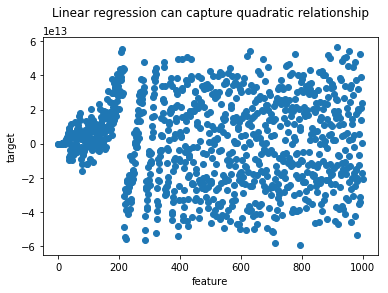

In [11]:
df = pd.DataFrame()

for i in range(len(lrm.coef_)):
    # Data from 0 to 999
    df["X-"+str(i+1)] = np.arange(0,1000,1)**(i+1)    #square, cube, etc

# Equation: Y = Intercept + Coeff[0]*X + Coeff[1]*X^2 + Coeff[2]*X^3 + Coeff[3]*X^4
equation = lrm.intercept_ 
for i in range(len(lrm.coef_)):
    equation = equation + (lrm.coef_[i]*df["X-"+str(i+1)])

df["Y"] = equation


# X is the feature set 
X = df[list(df.columns.drop('Y'))]
# Y is the target variable
Y = df['Y']

# Fit a linear regression where target is Y and features are X, X^2, X^3, and X^4
lrm_example = linear_model.LinearRegression()
lrm_example.fit(X,Y)

# predictions of the linear regression
predictions = lrm_example.predict(X)

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X-1"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship\n')
plt.show()

As you can see in the scatter plot shown above, the calculated coefficients did not provide a linear or quadratic relationship. We need to take that knowledge into account when redesigning our model. As long as we use a model that doesn't count on this linearity assumption, it's fine that this assumption didn't hold true.

### Assumption Two: Error Term should be Zero on Average

In [12]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the house price model is: {}".format(np.mean(errors)))

Mean of the errors in the house price model is: -0.00028493206304847264


This value is very close to zero, so this assumption holds true.

### Assumption Three: Homoscedasticity

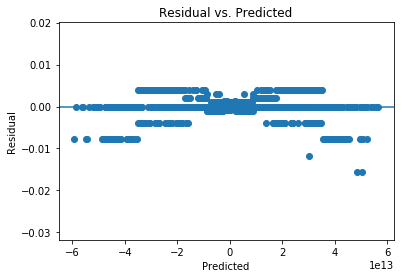

In [13]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [14]:
#Use Bartlett and Levene tests to check homoscedasticity
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 71929.7 and p value is 0
Levene test statistic value is 2085.06 and p value is 2.08e-312


Our error tends to be larger for the highest and lowest predicted values in the range. Therefore, we reject the null and conclude that our errors are heteroscedastic (not homoscedastic).

### Assumption Four: Low Multicollinearity

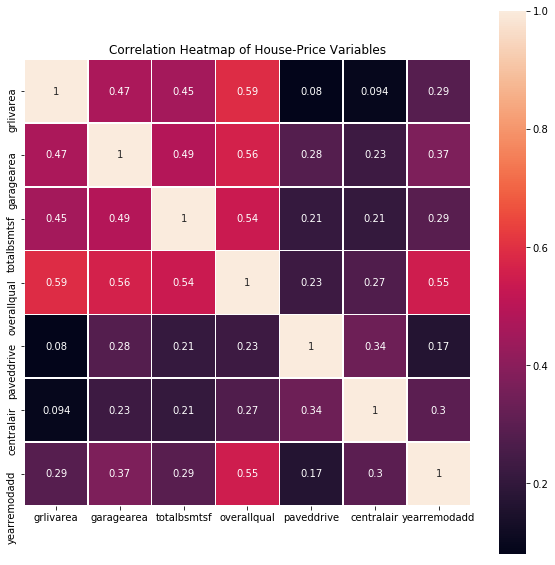

,grlivarea,garagearea,totalbsmtsf,overallqual,paveddrive,centralair,yearremodadd
grlivarea,1.000000,0.468997,0.454868,0.593007,0.080195,0.093666,0.287389
garagearea,0.468997,1.000000,0.486665,0.562022,0.284885,0.230741,0.371600
totalbsmtsf,0.454868,0.486665,1.000000,0.537808,0.210346,0.207958,0.291066
overallqual,0.593007,0.562022,0.537808,1.000000,0.229393,0.272038,0.550684
paveddrive,0.080195,0.284885,0.210346,0.229393,1.000000,0.337516,0.168457
centralair,0.093666,0.230741,0.207958,0.272038,0.337516,1.000000,0.298878
yearremodadd,0.287389,0.371600,0.291066,0.550684,0.168457,0.298878,1.000000


In [15]:
#Compare the continuous variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(sale_df[feature_set].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of House-Price Variables')
plt.show()

sale_df[feature_set].corr()

The correlations between these variables are higher than I feel comfortable with, although not so high that I can assume that they provide the exact same information. This can be addressed by removing one of the variables in a pair that have high correlation. The highest correlation can be seen between 'grlivarea' and 'overallqual', 'garagearea' and 'overallqual', and 'yearremodadd' and 'overallqual'. This indicates to me that 'overallqual' is a very important feature in predicting 'saleprice'.

### Assumption Five: Error Terms Should be Uncorrelated with One Another

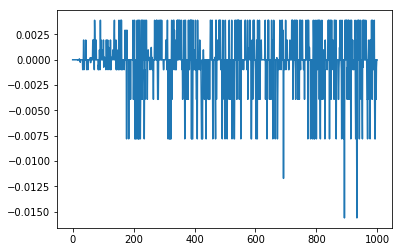

In [16]:
plt.plot(errors)
plt.show()

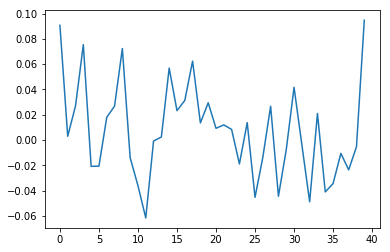

In [17]:
#Double-check with autocorrelation function
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The results of these plots seem to be very random, and the autocorrelation between errors of our model is very low (ranging between -0.06 and 0.1).

### Assumption Six: Features Shouldn't be Correlated with Errors

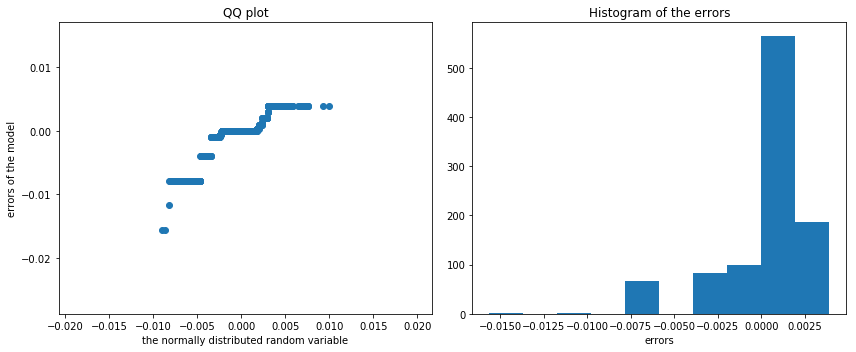

In [18]:
#Use histogram and QQ plot
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [19]:
#Visually, they don't look normally distributed
#Double-check with Jarque-Bera and Normality tests

from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 604.5866370337421 and p value is 0.0
Normality test statistics is 240.93644696910022 and p value is 4.8008185956522735e-53


Both tests result in a p-value of 0, leading us to conclude that the errors are not normally distributed. 

## Conclusions:
This model passes only 3 out of the 6 assumptions tested. Because so many of these assumptions aren't met, we must conclude that either our model must be changed significantly (different ranges of data/removed outliers, different features, etc) or we need to use a completely different type of regression.